In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img, to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
#from tensorflow.keras.utils import to_categorical

In [2]:
input_shape = (128, 128, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

In [3]:
print('fake len=', len(fake_data), 'real len=', len(real_data))

fake len= 2986 real len= 759


In [4]:
X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

In [5]:
# Check
print(np.array(X).shape)
print(np.array(Y).shape)
print(X[0:3])
print(Y[0:3])

(3745, 49152)
(3745,)
[array([0.38431373, 0.25490198, 0.21176471, ..., 0.28235295, 0.14509805,
       0.14901961], dtype=float32), array([0.1882353 , 0.1254902 , 0.11764706, ..., 0.40392157, 0.57254905,
       0.4627451 ], dtype=float32), array([0.17254902, 0.12941177, 0.11764706, ..., 0.39607844, 0.56078434,
       0.44313726], dtype=float32)]
[1, 1, 1]


In [6]:
Y_val_org = Y

# Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

In [7]:
print(X[0:2])
print(Y[0:2])
print(X.shape)

[[0.38431373 0.25490198 0.21176471 ... 0.28235295 0.14509805 0.14901961]
 [0.1882353  0.1254902  0.11764706 ... 0.40392157 0.57254905 0.4627451 ]]
[[0. 1.]
 [0. 1.]]
(3745, 49152)


In [8]:
# Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [9]:
print(len(X_train))
print(len(X_test))

2996
749


#### Training

InceptionResNetV2, EfficientNetB4

In [10]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
googleNet_model = EfficientNetB6(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True

model = Sequential()

165249024/165234480 [==============================] - 39s 0us/step


In [13]:
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 4, 4, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4610      
Total params: 40,964,753
Trainable params: 40,740,314
Non-trainable params: 224,439
_________________________________________________________________


C:\Users\sky\.conda\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
# Currently not used
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 30
BATCH_SIZE = 15
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2, verbose = 1)

Epoch 1/30
160/160 [==============================] - 69s 314ms/step - loss: 0.6765 - accuracy: 0.5785 - val_loss: 0.6828 - val_accuracy: 0.7883
Epoch 2/30
160/160 [==============================] - 47s 293ms/step - loss: 0.5928 - accuracy: 0.7492 - val_loss: 0.5644 - val_accuracy: 0.7883
Epoch 3/30
160/160 [==============================] - 46s 289ms/step - loss: 0.5064 - accuracy: 0.8255 - val_loss: 0.5175 - val_accuracy: 0.7883
Epoch 4/30
160/160 [==============================] - 46s 290ms/step - loss: 0.4174 - accuracy: 0.8669 - val_loss: 0.4951 - val_accuracy: 0.7867
Epoch 5/30
160/160 [==============================] - 47s 294ms/step - loss: 0.3219 - accuracy: 0.9069 - val_loss: 0.3621 - val_accuracy: 0.8600
Epoch 6/30
160/160 [==============================] - 46s 289ms/step - loss: 0.2552 - accuracy: 0.9240 - val_loss: 0.3062 - val_accuracy: 0.8950
Epoch 7/30
160/160 [==============================] - 46s 289ms/step - loss: 0.1974 - accuracy: 0.9399 - val_loss: 0.2616 - val_ac

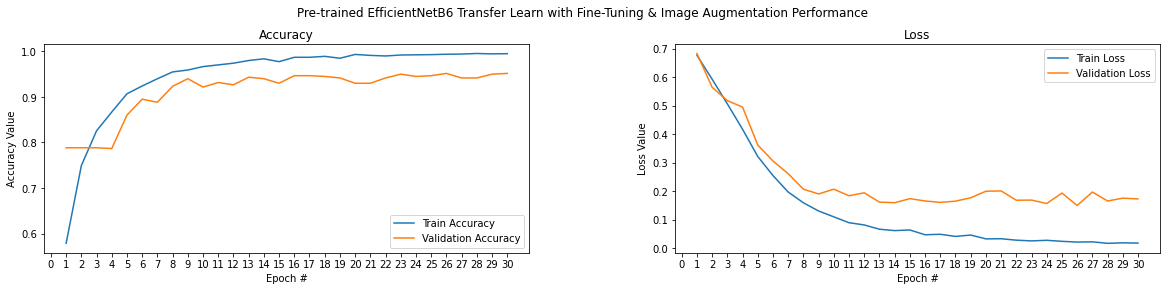

In [15]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained EfficientNetB6 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [16]:
# Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

In [21]:
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(Y_test, axis=1)
print(pred)
print(y_pred[0:4], y_true[0:4])

[[1.0000000e+00 1.1980581e-08]
 [9.9999940e-01 6.1450851e-07]
 [9.9999976e-01 2.3628535e-07]
 ...
 [9.9998939e-01 1.0614798e-05]
 [9.9997663e-01 2.3409240e-05]
 [1.1408944e-03 9.9885917e-01]]
[0 0 0 0] [0 0 0 0]


True positive =  566
False positive =  23
False negative =  21
True negative =  139




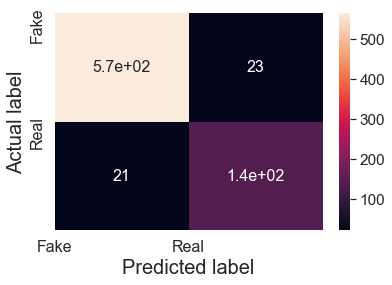

In [22]:
print_confusion_matrix(y_true, y_pred)

In [18]:
model.save('deepfake-detection-model-EfficientNetB5.h5')

C:\Users\sky\.conda\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
